In [1]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score

In [ ]:
import sys
import os

# os.path.dirname(__file__) doesn't work in notebooks, so we use os.getcwd()
# This gets the absolute path of the root (2 levels up from EDA folder)
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that root path to Python's search list
if root_path not in sys.path:
    sys.path.append(root_path)
from src.data_loader import load_data
df_raw =load_data()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Splitting the initial train and holdout test set 
df_train, df_test = train_test_split(df_raw, test_size=0.2, random_state=42, stratify=df_raw['isFraud'])

In [ ]:
# importing Feature engineering
from src.Feature_engg.Feature_Engineering import build_fraud_features

# importing trained model 
from src.Model.fraud_xgboost import (
    train_model,
    evaluate_model,
    save_model,
    load_model,
    predict_proba
)

print("Raw train+val:", df_train.shape)
print("Raw test     :", df_test.shape)


Raw train+val: (5090096, 11)
Raw test     : (1272524, 11)


In [5]:
# Applying feature engineering (preprocessing) on train and Holdout test data

train = build_fraud_features(df_train)
test = build_fraud_features(df_test)

print("Processed train+val:", train.shape)
print("Processed test     :", test.shape)

Processed train+val: (2216689, 6)
Processed test     : (553720, 6)


In [6]:
# Train and evaluate the model
model, X_val, y_val = train_model(train)
threshold = evaluate_model(model, X_val, y_val)

Validation ROC-AUC: 0.9984636183105245
Validation PR-AUC : 0.8970059799478755

Chosen Threshold (max F1): 0.99
Precision: 0.7881 | Recall: 0.8037 | F1: 0.7958

Confusion Matrix:
[[441740    284]
 [   258   1056]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9994    0.9994    442024
           1     0.7881    0.8037    0.7958      1314

    accuracy                         0.9988    443338
   macro avg     0.8937    0.9015    0.8976    443338
weighted avg     0.9988    0.9988    0.9988    443338



In [7]:
save_model(model,0.99, "../src/MODEL/fraud_Detection_model.pkl")
load_model("../src/MODEL/fraud_Detection_model.pkl")

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='auc', feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=500,
               n_jobs=-1, num_parallel_tree=None, ...),
 0.99)

In [8]:
# FINAL evaluation on HOLDOUT TEST (unbiased)

X_test = test.drop(columns=["isFraud"])
y_test = test["isFraud"]

test_proba = predict_proba(model, X_test)
test_preds = (test_proba >= threshold).astype(int)

print("\n--- HOLDOUT TEST RESULTS ---")
print("Test ROC-AUC:", roc_auc_score(y_test, test_proba))
print("Test PR-AUC :", average_precision_score(y_test, test_proba))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_preds))

print("\nClassification Report:")
print(classification_report(y_test, test_preds, digits=4))


--- HOLDOUT TEST RESULTS ---
Test ROC-AUC: 0.9980586519907445
Test PR-AUC : 0.9083845411331049

Confusion Matrix:
[[551709    368]
 [   298   1345]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9993    0.9994    552077
           1     0.7852    0.8186    0.8015      1643

    accuracy                         0.9988    553720
   macro avg     0.8923    0.9090    0.9005    553720
weighted avg     0.9988    0.9988    0.9988    553720



In [9]:
# ------------------------------
raw_example = pd.DataFrame([{
    "step": 105,
    "type": "TRANSFER",
    "amount": 90000,
    "oldbalanceOrg": 100000,
    "newbalanceOrig": 10000,
    "oldbalanceDest": 0,
    "newbalanceDest": 1000  # <-- not equal to 0 + 90000, so large abs_error_dest
}])

print("\nRaw input transaction:")
print(raw_example)

# Feature engineering (must match training)
fe = build_fraud_features(raw_example)

print("\nEngineered features passed to model:")
print(fe)

# Make prediction
proba = predict_proba(model, fe)[0]
pred = int(proba >= threshold)

print("\nRaw model output:")
print(f"Fraud probability (0-1): {proba:.6f}")
print(f"Threshold: {threshold:.6f}")
print(f"Predicted class (0=Not Fraud, 1=Fraud): {pred}")

print("\nInterpreting result:")
print(f"- {round(proba * 100, 4)}% fraud probability")
print(f"- {'FRAUD' if pred == 1 else 'NOT FRAUD'} at threshold {threshold:.6f}")



Raw input transaction:
   step      type  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0   105  TRANSFER   90000         100000           10000               0   

   newbalanceDest  
0            1000  

Engineered features passed to model:
   abs_error_dest  amount_to_oldbalanceOrg  orig_drop_ratio  \
0           89000                      0.9              0.9   

   orig_balance_delta  log_amount  
0               90000   11.407576  

Raw model output:
Fraud probability (0-1): 0.000805
Threshold: 0.990000
Predicted class (0=Not Fraud, 1=Fraud): 0

Interpreting result:
- 0.08049999922513962% fraud probability
- NOT FRAUD at threshold 0.990000


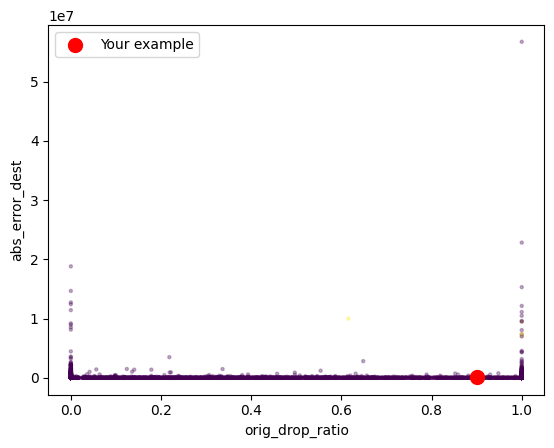

In [10]:
import matplotlib.pyplot as plt

# scatter of fraud vs non-fraud in 2D space
sample_plot = train.sample(20000)
plt.scatter(sample_plot['orig_drop_ratio'], sample_plot['abs_error_dest'], 
            c=sample_plot['isFraud'], alpha=0.3, s=5)
plt.scatter([0.9], [89000], c='red', s=100, label='Your example')
plt.xlabel('orig_drop_ratio')
plt.ylabel('abs_error_dest')
plt.legend()
plt.show()


In [11]:
raw_example2 = pd.DataFrame([{
    "step": 999,
    "type": "TRANSFER",
    "amount": 95000,
    "oldbalanceOrg": 100000,
    "newbalanceOrig": 1000,    # very large drop
    "oldbalanceDest": 500,
    "newbalanceDest": 50000   # doesn’t match any expected pattern
}])

fe2 = build_fraud_features(raw_example2)
print(fe2)
proba2 = predict_proba(model, fe2)[0]
print("Fraud probability:", proba2)


   abs_error_dest  amount_to_oldbalanceOrg  orig_drop_ratio  \
0           45500                     0.95             0.99   

   orig_balance_delta  log_amount  
0               99000   11.461643  
Fraud probability: 0.00016673973
